# ЧАСТЬ №1. ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ ФОНДОВОГО РЫНКА.

 <b>рынок:</b> Бразилия<br>
 <b>период:</b> 2018 год

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("..\data_log_return.csv")
tickers = list(data.columns)
tickers.pop(0)

'Date'

# 1. Оценка ожидаемых доходностей и стандартных отклонений.

Для того, чтобы оценить ожидаемые доходности и стандартные отклонения мы используем функции mean() и std(). В нашей табличке уже есть логарифмические доходности по дням для каждой акции. Именно их мы и будем использовать для подсчетов.

In [3]:
# Вычисление оценки ожидаемых доходностей и стандартных отклонений
def find_E_n_sigma(data, tickers):
    expected_returns = {}
    risks = {}

    for ticker in tickers:
        risk = data[ticker].std()
        expected_returns[ticker] = data[ticker].mean()
        risks[ticker] = risk

    risk_and_return = pd.DataFrame({
        'Ticker': expected_returns.keys(),
        'E': expected_returns.values(),
        'σ': risks.values()
    })

    return risk_and_return

risk_and_return = find_E_n_sigma(data, tickers)

Построем «карту» активов в системе координат (σ, E).

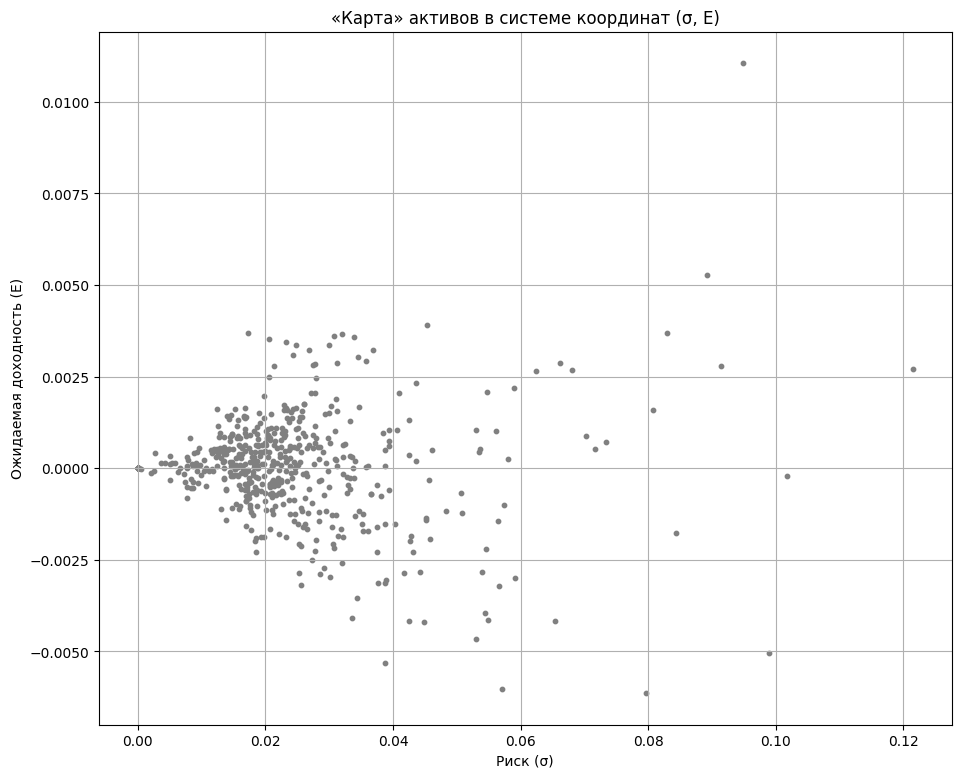

In [4]:
# Построение карты активов с выделенными выбранными.
plt.figure(figsize=(11, 9))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.grid()
plt.show()

# 2. Парето-оптимальные активы.

Парето-оптимальные активы - активы, характеристики которых нельзя улучшить сразу по двум критериям. Это значит, что нет активов у которых одновременно больше доходность и меньше риск.

In [5]:
# Функция для поиска Парето-оптимальных активов
pareto_optimal_assets = []

for i in range(len(risk_and_return['Ticker'])):
    current_E = risk_and_return['E'][i]
    current_Sigma = risk_and_return['σ'][i]
    is_optimal = True
    for j in range(len(risk_and_return['Ticker'])):
        if i != j:
            if (risk_and_return['E'][j] >= current_E and risk_and_return['σ'][j] <= current_Sigma):
                is_optimal = False
                break
    if is_optimal:
        pareto_optimal_assets.append(risk_and_return['Ticker'][i])

pareto_optimal = find_E_n_sigma(data, pareto_optimal_assets)
print(pareto_optimal)

      Ticker         E         σ
0   AZEV3.SA  0.005261  0.089274
1   CEGR3.SA  0.000819  0.008155
2   CPFE3.SA  0.001613  0.012433
3   EQPA6.SA  0.011053  0.094818
4   HETA3.SA  0.000010  0.000160
5   IRBR3.SA  0.003700  0.017212
6  LILY34.SA  0.001648  0.016880
7   LOGN3.SA  0.003912  0.045399
8  MRCK34.SA  0.001626  0.015278
9  NPAR11.SA  0.000408  0.002748


Всего у нас получилось 10 Парето-оптимальных активев. Теперь покажем их на общей карте.

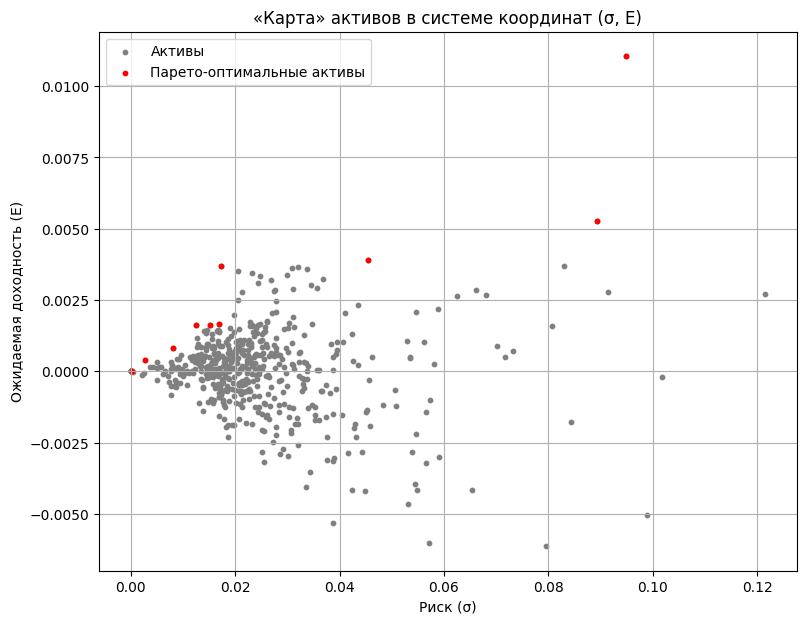

In [6]:
# Построение карты активов в системе координат (σ, E)
plt.figure(figsize=(9, 7))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey', label='Активы')
plt.scatter(pareto_optimal['σ'], pareto_optimal['E'], s=10, color='red', label='Парето-оптимальные активы')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.legend()
plt.grid()
plt.show()

# 3. Value at Risk и Conditional Value at Risk
### - Оценка VaR / CVaR с уровнем доверия 0,95 для Парето-оптимальных активов рынка.
### - Какие из активов наиболее предпочтительны по этим характеристикам?
### - Где они расположены на карте активов?
### - Сравнить результаты VaR и CVaR

Мы нашли Парето-оптимальные активы и теперь мы сделаем небольшую таблицу с логарифмическими доходностями для этих активов.

In [7]:
portfolio_returns = pd.DataFrame()
ticker_returns = pd.DataFrame()

for ticker in pareto_optimal_assets:
    ticker_returns['log_return'] = pd.DataFrame(data[ticker]).reset_index(drop=True)
    portfolio_returns[ticker] = ticker_returns['log_return']
portfolio_returns['Portfolio Returns'] = portfolio_returns.sum(axis=1)

In [8]:
def historicalVaR(returns, alpha):

    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha):

    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 4. Распределение доходностей конкретного актива
### - Выбор нескольких интересных (значимых) активов рынка.
### - Можно ли считать наблюдаемые доходности конкретного актива повторной выборкой из некоторого распределения (белый шум)?
### - Поиск научных подходов к ответу на этот вопрос.

Сначала выберем 5 тикеров которые торговали максимум дней (246). Тк как у нас обязательно у каждого актива 2018-01-01 = NaN, то должно получится 245 строчек. Если логарифмическая доходность равна нулю, то это значит, что по сравнению с предыдущим днем цена актива не поменялась. Мы хотим найти активы с минимальных количеством таких дней. И последнее условие - ожидаемая доходность должна быть больше нуля.

In [17]:
selected_tickers = []
for ticker in tickers:
    returns = data[ticker].dropna() # Удаляем NaN, если они есть
    lst = data[ticker].tolist()
    if returns.shape[0] == 245 and lst.count(0) <= 1 and risk_and_return.loc[risk_and_return['Ticker'] == ticker]['E'].values[0] > 0:
        selected_tickers.append(ticker)
    if len(selected_tickers) >= 5:
        break

print(selected_tickers)

['AMER3.SA', 'CVCB3.SA', 'ITUB4.SA', 'MGLU3.SA', 'PSSA3.SA']


Мы нашли 5 активов, у которых всего 1 log return = 0. Их мы и будем исследовать.

# 5. Нормальность распределений доходностей
### - В предположении, что наблюдаемые доходности выбранных активов являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей выбранных активов.
### - Можно ли считать, что распределения доходностей подчиняются нормальному закону распределения?
### - Если ответ отрицательный, какие другие законы распределения доходностей соответствуют данным наблюдений?


Для наглядности распределения доходностей изобразим их на гистограме и Q-Q plot. Q-Q plot помогает оценить степень отклонения данных от теоретического распределения. В нашем случае отклонение от нормального распределения. Будем использовать тест Шапиро-Уилка, чтобы понять пожчиняются ли распределения нормальному закону. 

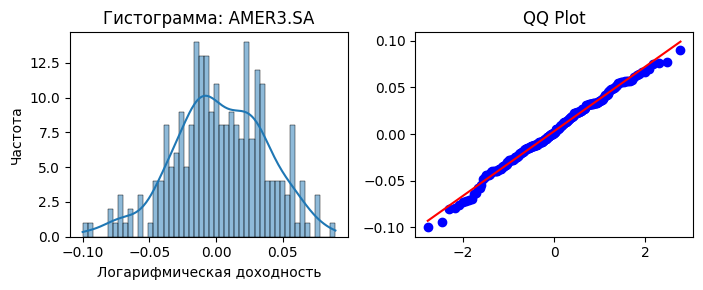

Актив: AMER3.SA 

Статистика = 0.9932465745374831, p-значение = 0.3335745398032673
Распределение логарифмических доходностей можно считать нормальным (p > 0.05) 



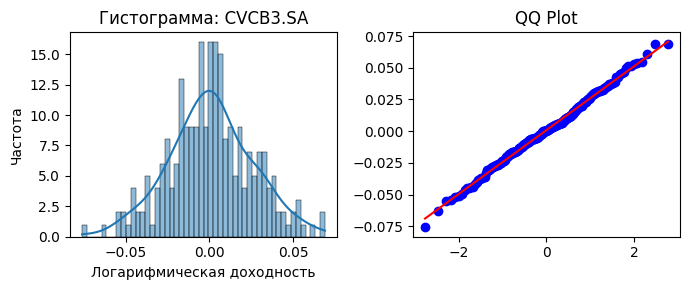

Актив: CVCB3.SA 

Статистика = 0.9963975168030549, p-значение = 0.848632061755241
Распределение логарифмических доходностей можно считать нормальным (p > 0.05) 



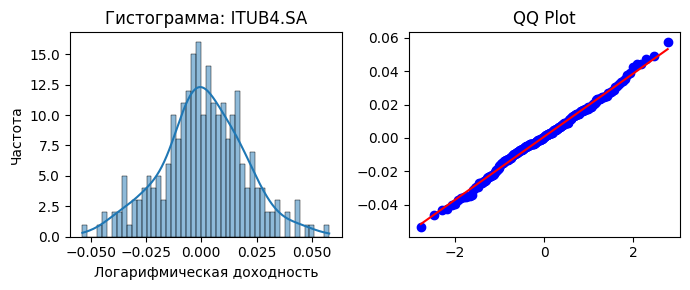

Актив: ITUB4.SA 

Статистика = 0.9948154328909589, p-значение = 0.5731480522161849
Распределение логарифмических доходностей можно считать нормальным (p > 0.05) 



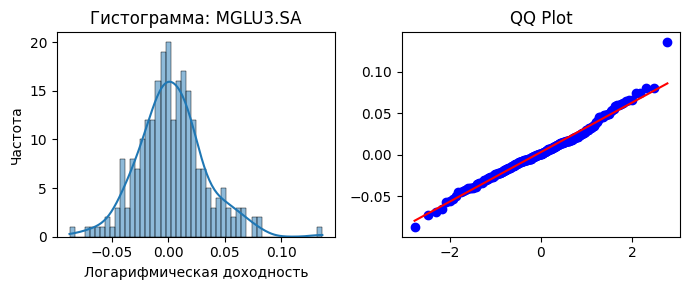

Актив: MGLU3.SA 

Статистика = 0.9819742335012964, p-значение = 0.0033444789035238336
Распределение логарифмических доходностей не является нормальным (p <= 0.05) 



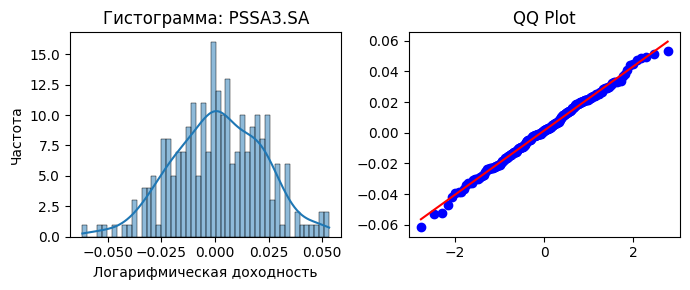

Актив: PSSA3.SA 

Статистика = 0.9962545804870233, p-значение = 0.8264284753644706
Распределение логарифмических доходностей можно считать нормальным (p > 0.05) 



In [19]:
import seaborn as sns
from scipy import stats

for ticker in selected_tickers:
    returns = data[ticker].dropna() # Удаляем NaN, если они есть

    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    sns.histplot(returns, bins=50, kde=True)
    plt.title(f'Гистограмма: {ticker}')
    plt.xlabel('Логарифмическая доходность')
    plt.ylabel('Частота')

    # QQ plot
    plt.subplot(1, 2, 2)
    stats.probplot(returns, dist="norm", plot=plt)
    plt.title(f'QQ Plot')
    plt.xlabel('')
    plt.ylabel('')

    # Показ графиков
    plt.tight_layout()
    plt.show()

    print('Актив:', ticker, '\n')

    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(returns)
    print(f'Статистика = {stat}, p-значение = {p_value}')
    if p_value > 0.05:
        print(f'Распределение логарифмических доходностей можно считать нормальным (p > 0.05) \n')
    else:
        print(f'Распределение логарифмических доходностей не является нормальным (p <= 0.05) \n')

    print('='*90)

Как бы стрнанно не выглядели некоторые графики, но тест Шапира-Уилка и Q-Q plot показывают, что доходности 4 из 5 выбранных активов подчиняются нормальному закону распределения.

Актив 'MGLU3.SA' среди доходностей имеет один выброс и, не смотря на, можно сказать, самую красивую гистограмму, не подчиняется нормальному закону распределения.

# 6. Поиск чего-нибудь интересного (необычного) на рынке.